In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path


CLEAN_PATH = Path("../../data/cleaned/yellow_tripdata_cleaned.csv")
KPI_DIR = Path("../../outputs/kpis_output")
KPI_DIR.mkdir(parents=True, exist_ok=True)

print("KPI directory ready:", KPI_DIR.resolve())
print(CLEAN_PATH.resolve())






KPI directory ready: C:\Users\ARADHAY\Desktop\Blend\Capstone\outputs\kpis_output
C:\Users\ARADHAY\Desktop\Blend\Capstone\data\cleaned\yellow_tripdata_cleaned.csv


In [ ]:
df = pd.read_csv(CLEAN_PATH, parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
print("Loaded:", df.shape)

df.head()

Loaded: (79501, 30)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,pickup_hour,pickup_day,pickup_month,pickup_quarter,trip_duration_min,revenue_per_mile,tip_percentage,is_weekend,is_peak_hour,fare_per_minute
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,...,19,Thursday,1,1,18.050000,10.723270,27.083333,False,True,0.664820
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,...,20,Saturday,1,1,19.833333,5.393939,13.793103,True,False,0.731092
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,...,20,Saturday,1,1,10.050000,6.000000,0.000000,True,False,0.945274
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,...,20,Saturday,1,1,1.866667,9.600000,0.000000,True,False,1.875000
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,...,20,Saturday,1,1,19.316667,5.433333,0.000000,True,False,0.776531


In [28]:
summary_kpis = {
    "total_revenue": df["total_amount"].sum(),
    "avg_trip_distance": df["trip_distance"].mean(),
    "avg_fare": df["fare_amount"].mean(),
    "avg_tip_percentage": df["tip_percentage"].mean(),
    "avg_revenue_per_mile": df["revenue_per_mile"].mean(),
    "total_trips": len(df),
    "zero_tip_rate_pct": (df["tip_amount"] == 0).mean() * 100,
    "avg_trip_duration_min": df["trip_duration_min"].mean(),
}

summary_df = pd.DataFrame([summary_kpis])
summary_df.to_csv(KPI_DIR / "summary_kpis.csv", index=False)
summary_df



,total_revenue,avg_trip_distance,avg_fare,avg_tip_percentage,avg_revenue_per_mile,total_trips,zero_tip_rate_pct,avg_trip_duration_min
0,1203737.86,2.893167,12.117687,14.047832,8.013819,79501,36.101433,14.887687


In [29]:
df["year_month"] = df["tpep_pickup_datetime"].dt.to_period("M").astype(str)

monthly_revenue = (
    df.groupby("year_month")
      .agg(
          trips=("total_amount", "count"),
          revenue=("total_amount", "sum")
      )
      .reset_index()
)

monthly_revenue.to_csv(KPI_DIR / "monthly_revenue.csv", index=False)
monthly_revenue.head()


,year_month,trips,revenue
0,2015-01,19865,294726.64
1,2016-01,19831,293710.55
2,2016-02,19895,315094.13
3,2016-03,19910,300206.54


In [30]:
hourly_demand = (
    df.groupby("pickup_hour")
      .agg(
          trips=("total_amount", "count"),
          revenue=("total_amount", "sum")
      )
      .reset_index()
      .sort_values("pickup_hour")
)

hourly_demand.to_csv(KPI_DIR / "hourly_demand.csv", index=False)
hourly_demand.head()



,pickup_hour,trips,revenue
0,0,3643,56491.73
1,1,8999,132387.27
2,2,6911,103623.63
3,3,1626,24798.42
4,4,65,1180.21


In [31]:
def bucket_hour(h):
    if (7 <= h <= 10) or (17 <= h <= 20):
        return "peak"
    return "off_peak"

df["time_bucket"] = df["pickup_hour"].apply(bucket_hour)

peak_vs_offpeak = (
    df.groupby("time_bucket")
      .agg(
          trips=("total_amount", "count"),
          revenue=("total_amount", "sum"),
          avg_fare=("fare_amount", "mean")
      )
      .reset_index()
)

peak_vs_offpeak.to_csv(KPI_DIR / "peak_vs_offpeak.csv", index=False)
peak_vs_offpeak



,time_bucket,trips,revenue,avg_fare
0,off_peak,46131,704516.20,12.216502
1,peak,33370,499221.66,11.981084


In [32]:
weekday_revenue = (
    df.groupby("pickup_day")
      .agg(
          trips=("total_amount", "count"),
          revenue=("total_amount", "sum"),
          avg_fare=("fare_amount", "mean")
      )
      .reset_index()
)

weekday_revenue.to_csv(KPI_DIR / "weekday_revenue.csv", index=False)
weekday_revenue


,pickup_day,trips,revenue,avg_fare
0,Friday,23873,373592.70,12.354365
1,Monday,1846,28785.92,12.371143
2,Saturday,21576,316552.66,11.858853
3,Sunday,2822,41909.69,12.091779
4,Thursday,23962,361922.98,12.164109
5,Tuesday,2507,37239.87,11.726502
6,Wednesday,2915,43734.04,11.914580


In [33]:
def distance_bucket(d):
    if d < 2:
        return "short_<2km"
    elif d <= 5:
        return "medium_2_5km"
    else:
        return "long_>5km"

df["distance_bucket"] = df["trip_distance"].apply(distance_bucket)

distance_buckets = (
    df.groupby("distance_bucket")
      .agg(
          trips=("total_amount", "count"),
          revenue=("total_amount", "sum"),
          avg_fare=("fare_amount", "mean")
      )
      .reset_index()
)

distance_buckets.to_csv(KPI_DIR / "distance_buckets.csv", index=False)
distance_buckets



,distance_bucket,trips,revenue,avg_fare
0,long_>5km,11160,411970.90,30.168608
1,medium_2_5km,24173,390342.43,13.171187
2,short_<2km,44168,401424.53,6.980154


In [34]:
trip_duration_stats = pd.DataFrame([{
    "avg_duration_min": df["trip_duration_min"].mean(),
    "p90_duration_min": df["trip_duration_min"].quantile(0.90),
    "max_duration_min": df["trip_duration_min"].max()
}])

trip_duration_stats.to_csv(KPI_DIR / "trip_duration_stats.csv", index=False)
trip_duration_stats


,avg_duration_min,p90_duration_min,max_duration_min
0,14.887687,23.866667,1439.433333


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../../data/cleaned/yellow_tripdata_cleaned.csv", parse_dates=[
    "tpep_pickup_datetime", "tpep_dropoff_datetime"
])


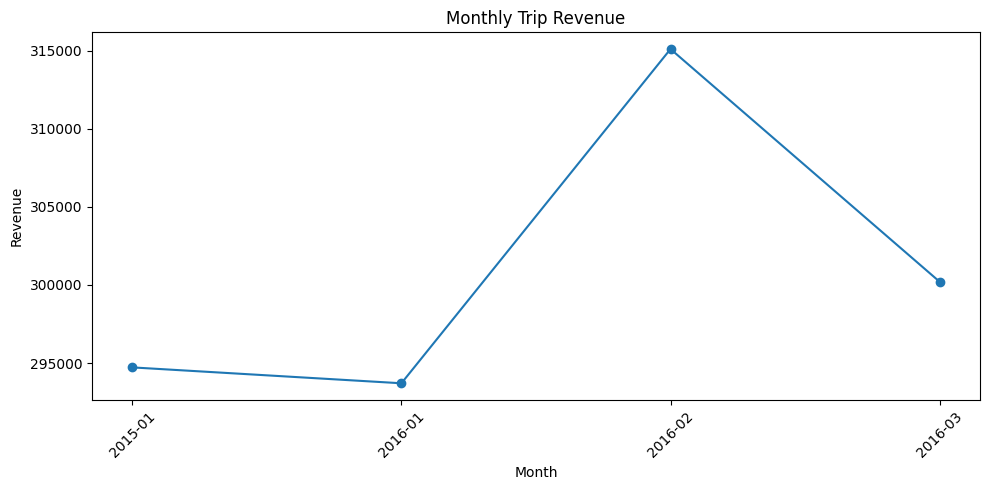

In [18]:

monthly_revenue = (
    df.groupby(df["tpep_pickup_datetime"].dt.to_period("M"))["total_amount"]
    .sum()
    .reset_index()
)
monthly_revenue["tpep_pickup_datetime"] = monthly_revenue["tpep_pickup_datetime"].astype(str)

monthly_revenue.to_csv("../../data/kpis/monthly_revenue.csv", index=False)

plt.figure(figsize=(10, 5))
plt.plot(monthly_revenue["tpep_pickup_datetime"], monthly_revenue["total_amount"], marker="o")
plt.title("Monthly Trip Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../../outputs/visuals/monthly_revenue_trend.png")
plt.show()


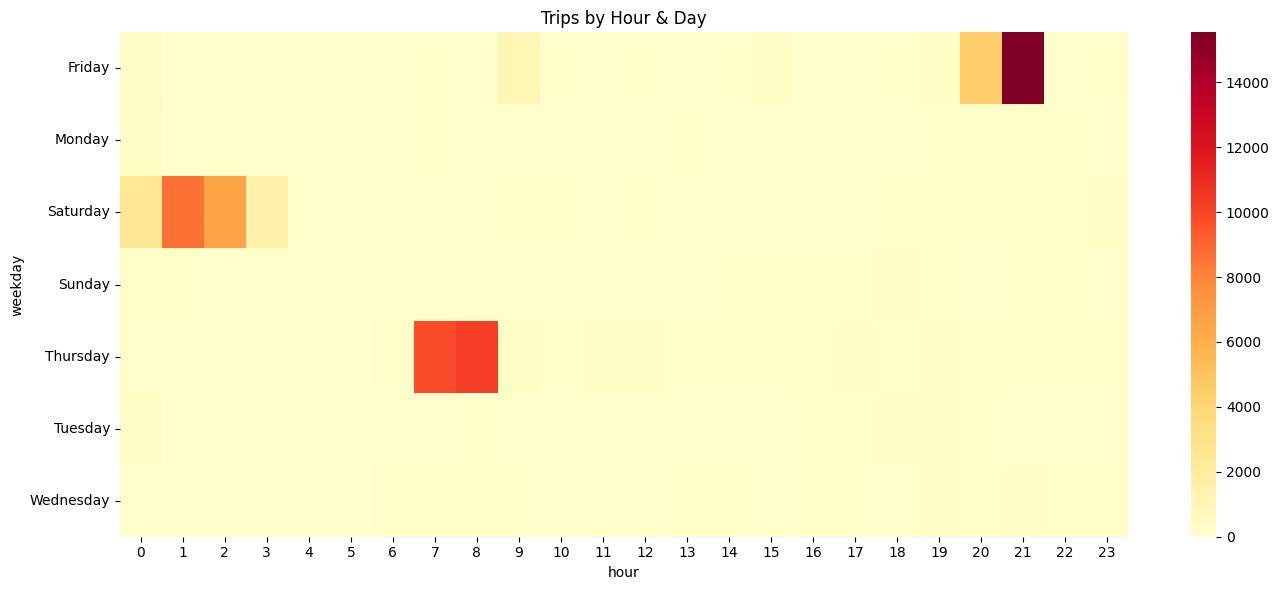

In [ ]:
df["hour"] = df["tpep_pickup_datetime"].dt.hour
df["weekday"] = df["tpep_pickup_datetime"].dt.day_name()

heatmap_data = pd.pivot_table(
    df, values="VendorID",
    index="weekday", columns="hour",
    aggfunc="count"
).fillna(0)

heatmap_data.to_csv("../../data/kpis/hourly_demand_matrix.csv")

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd")
plt.title("Trips by Hour & Day")
plt.tight_layout()
plt.savefig("../../outputs/visuals/hourly_demand_heatmap.png")
plt.show()


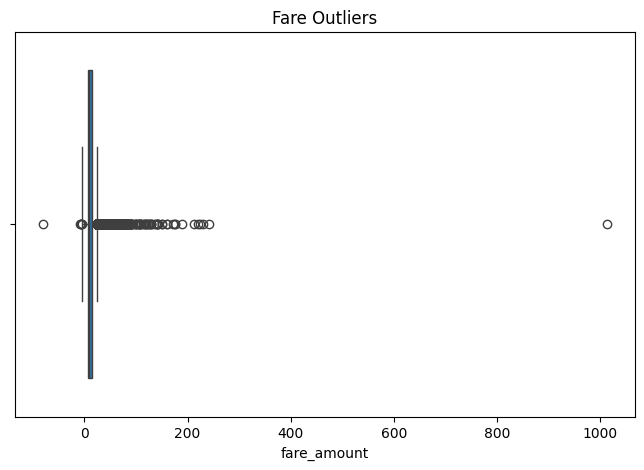

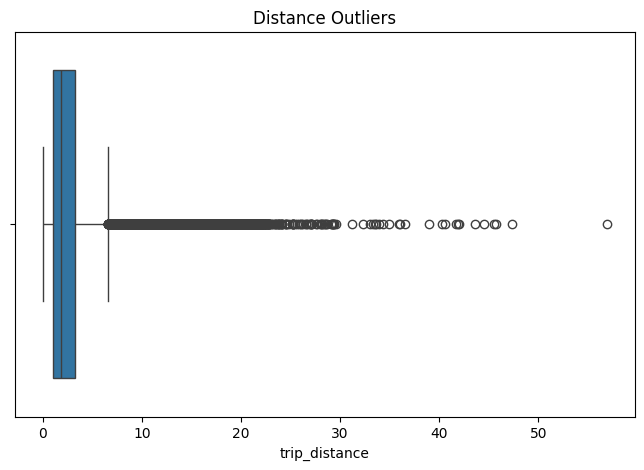

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["fare_amount"])
plt.title("Fare Outliers")
plt.savefig("../../data/visuals/fare_outliers.png")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x=df["trip_distance"])
plt.title("Distance Outliers")
plt.savefig("../../outputs/visuals/distance_outliers.png")
plt.show()



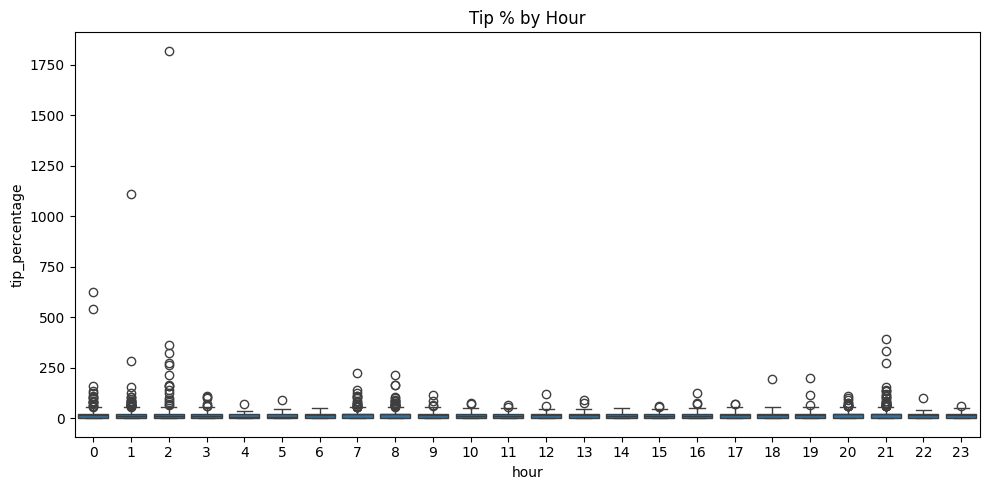

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x="hour", y="tip_percentage", data=df)
plt.title("Tip % by Hour")
plt.tight_layout()
plt.savefig("../../outputs/visuals/tip_by_hour.png")
plt.show()

